# Convolutions neural nets from scratch

The goal of this document is to document my attempt to build and apply neural networks to DNA sequence data, specifically to sgRNA screening data.  The motivation of this document is Andrej Karpathy's Hacker's guide to Neural Networks. Like his work we will build our models up, starting from a one layer network on up.  The hope is that I can gain a better understanding of building deep networks and backpropagation by working my way up.  

In our data we have a 40 base pair sequence (20 bp of the sgRNA + 3 bp PAM + 10 bp upstream + 10 bp downstream - 2 bp (NGG PAM) - 1 bp from G in first position).  We'll pass each of the 4 bases in each position to a single neuron (40 in the first layer).  For each neuron $i$ in the first layer, we'll compute a score $s_{i} = a_{i} 1(A) + c_{i} 1(C) + g_{i} 1(G) + t_{i} 1(T)$ and then apply ReLU transformation (relu(x) = $\max(0, x)$).  The transformed score is then passed to a regression model, i.e. 
$$
\hat{y}_{i} = \sum_{i = 1}^{40} \beta_{i} \text{relu}(s_{i}).
$$
We'll use square loss from the observed data to train the model.

In [8]:
import numpy
import pandas
import math

In [9]:
class neuron:
    def __init__(self, a, c, g, t):
        self.a = a
        self.c = c
        self.g = g
        self.t = t
        self.grad = [0.0]*4
    def set_params(self, a, c, g, t):
        self.a = a
        self.c = c
        self.g = g
        self.t = t
    def get_params(self):
        return [self.a, self.c, self.g, self.t]
    def compute_score(self, A, C, G, T):
        self.score = max(self.a*A + self.c*C + self.g*G + self.t*T, 0.0)
        return self.score
    def compute_gradient(self, A, C, G, T):
        if self.score < 0:
            self.grad = [0.0]*4
        else:
            self.grad = [A, C, G, T]
    def backward(self, A, C, G, T, prev_grad):
        self.compute_gradient(A, C, G, T)
        self.grad = numpy.multiply(self.grad, prev_grad)


class regression_gate:
    def __init__(self, n_params):
        self.n_params = n_params
        r = numpy.random.normal(0, 1, n_params)
        self.params = r/sum(r)
        self.grad = [0.0]*n_params
    def set_params(self, params):
        # make sure the lengths are correct
        assert len(params) == self.n_params, "wrong input length"
        self.params = params
    def compute_score(self, x):
        assert len(x) == self.n_params, "wrong input length"
        ret = 0.0
        for i in range(self.n_params):
            ret += self.params[i]*x[i]
        self.score = ret
        return ret
    def compute_gradient(self, x):
        self.grad = x
    def backward(self, x, prev_grad):
        self.compute_gradient(x)
        self.grad = numpy.multiply(x, prev_grad)
        
class logistic_regression_gate:
    def __init__(self, n_params):
        self.n_params = n_params
        self.params = numpy.random.normal(0, 1, n_params)
        self.grad = [0.0]*n_params
    def set_params(self, params):
        # make sure the lengths are correct
        assert len(params) == self.n_params, "wrong input length"
        self.params = params
    def compute_score(self, x):
        assert len(x) == self.n_params, "wrong input length"
        ret = 0.0
        for i in range(self.n_params):
            ret += self.params[i]*x[i]
        self.score = 1 / (1 + math.exp(-ret))
        return self.score
    def compute_gradient(self, x):
        self.compute_score(x)
        self.grad = self.score*(1 - self.score)*x
    def backward(self, x, prev_grad):
        self.compute_gradient(x)
        self.grad = numpy.multiply(x, prev_grad)


In [10]:
NeuronTopGeneGuidesMixtureProbs = pandas.read_csv("~/sgRNA/tiling/deepLearningMixtureRegression/NeuronTopGeneGuidesMixtureProbs.txt", sep='\t', header=0)
SelfRenewalTopGeneGuidesMixtureProbs = pandas.read_csv("~/sgRNA/tiling/deepLearningMixtureRegression/SelfRenewalTopGeneGuidesMixtureProbs.txt", sep='\t', header=0)
combinedGuides = pandas.concat([NeuronTopGeneGuidesMixtureProbs, SelfRenewalTopGeneGuidesMixtureProbs], ignore_index=True)

splitSeqs = []
for i in range(combinedGuides.shape[0]):
    splitSeqs = splitSeqs + list(str(combinedGuides["seq"][i]))

splitSeqsDF = pandas.DataFrame(numpy.array(splitSeqs).reshape(combinedGuides.shape[0], 43))
splitSeqsDummies = pandas.get_dummies(splitSeqsDF)
splitSeqsDummies.shape

(2073, 163)

In [11]:
splitSeqsDummies.drop([col for col, val in splitSeqsDummies.sum().iteritems() if val == 2073], axis=1, inplace=True)
splitSeqsDummies.shape

(2073, 160)

In [12]:
dataset = splitSeqsDummies
dataset["y"] = combinedGuides["mixture_probs"]

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.shape

(1658, 161)

In [13]:
train_outcome = train_dataset.pop('y')
test_outcome = test_dataset.pop('y')

In [14]:
import random
import matplotlib.pyplot as plt

neurons = []
for i in range(40):
    r = numpy.random.normal(0, 1, 4)
    n = neuron(a = r[0], c = r[1], g = r[2], t = r[3])
    neurons.append(n)
    
pooled_regression = regression_gate(41)

iter = 3000
epsilon = 1.0e-4
mse_train = []
mse_test = []
n_bases = 40

# sgd
for i in range(iter):
    indx = random.randint(0, len(train_outcome) - 1)
    x = train_dataset.iloc[indx]
    y = train_outcome.iloc[indx]
    # compute regression with current coefficients
    neuron_vals = [1.0] # first val is constant
    for j in range(n_bases):
        A = x.iloc[4*j]
        C = x.iloc[4*j + 1]
        G = x.iloc[4*j + 2]
        T = x.iloc[4*j + 3]
        neuron_vals.append(neurons[j].compute_score(A, C, G, T))
    #print("neuron vals = ", neuron_vals)
    prev_score = pooled_regression.compute_score(neuron_vals)
    #print("prev score = ", prev_score)
    #print("current val = ", y)
    #print("prev_score - y = ", prev_score - y)
    prev_diff = prev_score - y
    # compute gradient by backprop
    prev_grad = [prev_score - y]*41
    pooled_regression.backward(neuron_vals, prev_grad)
    #print("pooled_regression.params = ", pooled_regression.params)
    #print("pooled_regression.grad = ", pooled_regression.grad)
    for j in range(40):
        A = x.iloc[4*j]
        C = x.iloc[4*j + 1]
        G = x.iloc[4*j + 2]
        T = x.iloc[4*j + 3]
        prev_grad = pooled_regression.grad[j + 1]
        neurons[j].backward(A, C, G, T, prev_grad)
    # update params
    pooled_regression.set_params(pooled_regression.params - epsilon*pooled_regression.grad)
    for j in range(40):
        grad = neurons[j].grad
        neurons[j].set_params(neurons[j].a - epsilon*grad[0], 
                              neurons[j].c - epsilon*grad[1], 
                              neurons[j].g - epsilon*grad[2], 
                              neurons[j].t - epsilon*grad[3])
    neuron_vals = [1.0] # first val is constant
    for j in range(40):
        A = x.iloc[4*j]
        C = x.iloc[4*j + 1]
        G = x.iloc[4*j + 2]
        T = x.iloc[4*j + 3]
        neuron_vals.append(neurons[j].compute_score(A, C, G, T))
    current_score = pooled_regression.compute_score(neuron_vals)
    curr_diff = current_score - y
    if abs(prev_diff) < abs(curr_diff):
        print("score not improved!")
    #print("current score = ", current_score)
    e = 0.0
    for k in range(len(train_outcome)):
        neuron_vals = [1.0] # first val is constant
        x = train_dataset.iloc[k] 
        for j in range(40):
            A = x.iloc[4*j]
            C = x.iloc[4*j + 1]
            G = x.iloc[4*j + 2]
            T = x.iloc[4*j + 3]
            neuron_vals.append(neurons[j].compute_score(A, C, G, T))
        y = train_outcome.iloc[k]
        y_hat = pooled_regression.compute_score(neuron_vals)
        e += numpy.multiply(y - y_hat, y - y_hat)
    mse_train.append(e/len(train_outcome))
    e = 0.0
    for k in range(len(test_outcome)):
        neuron_vals = [1.0] # first val is constant
        x = test_dataset.iloc[k] 
        for j in range(40):
            A = x.iloc[4*j]
            C = x.iloc[4*j + 1]
            G = x.iloc[4*j + 2]
            T = x.iloc[4*j + 3]
            neuron_vals.append(neurons[j].compute_score(A, C, G, T))
        y = test_outcome.iloc[k]
        y_hat = pooled_regression.compute_score(neuron_vals)
        e += numpy.multiply(y - y_hat, y - y_hat)
    mse_test.append(e/len(test_outcome)) 

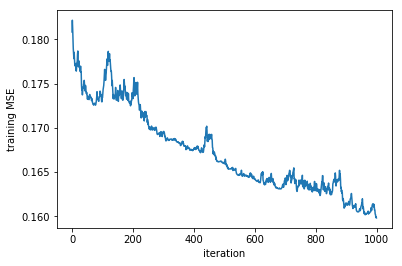

In [19]:
plt.plot(range(len(mse_train)), mse_train)
plt.xlabel('iteration')
plt.ylabel('training MSE')
plt.show()

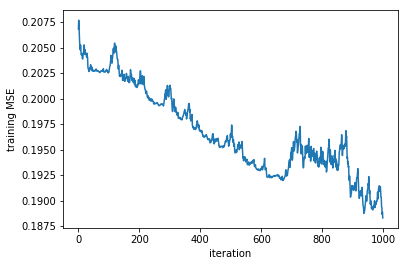

In [20]:
plt.plot(range(len(mse_test)), mse_test)
plt.xlabel('iteration')
plt.ylabel('training MSE')
plt.show()

It works!  We can quantify each base's contribution to the prediction by looking at the product of the regression coefficient for that base and then multplying that by the base's coefficient in the neuron.  

In [22]:
base_effects = numpy.zeros((4, 40))
for b in range(base_effects.shape[0]):
    for i in range(base_effects.shape[1]):        
        base_effects[b, i] = neurons[i].get_params()[b]*pooled_regression.params[i + 1]
plt.pcolor(base_effects)

(4, 40)